# Analyze GPT Annotations

In [48]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import json
import re

import pandas as pd
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
anno_filepath = 'data/gpt_requests_results.jsonl'

In [3]:
with open(anno_filepath, 'r') as f:
    annos = [json.loads(line) for line in f]

In [4]:
annos[0]

['M01000EYZ',
 {'model': 'gpt-3.5-turbo',
  'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'},
   {'role': 'user',
    'content': 'Circumplex theory is a social psychology based theory that characterizes social interactions between speakers. The social orientation tagset includes: {Assured-Dominant, Gregarious-Extraverted, Warm-Agreeable, Unassuming-Ingenuous, Unassured-Submissive, Aloof-Introverted, Cold, Arrogant-Calculating}, which are defined below in more detail.\n\nAssured-Dominant - Demands to be the center of interest / Demands attention, Does most of the talking, Speaks loudly, Is firm, Is self-confident, Is forceful, Is ambitious, Is assertive, Is persistent, Is domineering, Not self-conscious\n\nGregarious-Extraverted - Feels comfortable around people, Starts conversations, Talks to a lot of different people, Loves large groups, Is friendly, Is enthusiastic, Is warm, Is extraverted, Is good-natured, Is cheerful / happy, Is pleasant, Is outgoing, Is a

## Data preprocessing
1. Iterate over annos and for each file ID encountered, add it to a dict mapping file ID to a list of results
1. Extract GPT response
1. Write a RegEx to extract the speaker, utterance(s) IDs, label, and explanation
1. Load the source DF and merge
1. Assess how much data we got and how much we're missing

Other tasks:
1. Assess how often the GPT ran out of tokens vs. finishing all annotations and modify prompt length accordingly
1. Prepare next round of data for annotation

### Extract GPT responses

In [184]:
responses = defaultdict(list)
input_output = defaultdict(list)
for anno in annos:
    file_id, prompt, response = anno
    generated_content = response['choices'][0]['message']['content']
    # split on newlines (with some lookahead) to handle (e.g. M01000GBL)
    # Speaker 1 (193): Unassuming-Ingenuous - Takes things as they come, Tells the truth, Not self-centered, Is straightforward
    # Explanation: The speaker is stating a fact about themselves.
    split_content = generated_content.split('\n')
    lines = []
    i = 0
    while i < len(split_content):
        line = split_content[i]
        if line == '':
            i += 1
            continue
        if i < len(split_content) - 1:
            lookahead = split_content[i+1]
            if lookahead.startswith('Explanation:'):
                line += '. ' + lookahead
                i += 1
            # elif lookahead == '' and i < len(split_content) - 2:
            #     lookahead = split_content[i+2]
            #     line += '. ' + lookahead
            #     i += 2
        lines.append(line)
        i += 1
    
    responses[file_id].extend(lines)
    input_output[file_id].append((prompt, response))

In [185]:
labels = []
label_obj = defaultdict(list)
for file_id in responses:
    for line in responses[file_id]:
        label = utils.Label(file_id, line)
        label_obj[file_id].append(label)
        labels.extend(label.data)

In [186]:
# create dataframe
df = pd.DataFrame(labels, columns=['file_id', 'social_orientation', 'utterance_id', 'speaker_id', 'label_str'])

## Load source dataframe and merge

In [227]:
source_filepath = '~/Documents/data/charm/transformed/circumplex/gpt_prompts_r1_mini_eval_text.csv'
source_df = pd.read_csv(source_filepath)

In [228]:
source_df.head()

,filename,@id,@start_char,@end_char,ORIGINAL_TEXT,@type,@begin_offset,@char_length,id,time,...,TOKEN,social_orientation_random,file_id,timestamp,impact_scalar,comment,Utterance ID,Complete Line,Complete Line Length,line_len_cumsum
0,M01000EY0.ltf.xml,segment-0,0,11,你手机充300不够是吧？,message,0,14,m0000,2012-07-09 08:54:39 UTC,...,"[{'@id': 'token-0-0', '@pos': 'word', '@morph'...",Cold,M01000EY0,NaN,NaN,NaN,1,Speaker 1 (1): 你手机充300不够是吧？,20,20
1,M01000EY0.ltf.xml,segment-1,14,20,115.51？,message,14,9,m0001,2012-07-09 08:56:50 UTC,...,"[{'@id': 'token-1-0', '@pos': 'word', '@morph'...",Warm-Agreeable,M01000EY0,NaN,NaN,NaN,2,Speaker 2 (2): 115.51？,12,32
2,M01000EY0.ltf.xml,segment-2,23,27,我都糊涂了,message,23,7,m0002,2012-07-09 08:56:53 UTC,...,"[{'@id': 'token-2-0', '@pos': 'word', '@morph'...",Arrogant-Calculating,M01000EY0,NaN,NaN,NaN,3,Speaker 2 (3): 我都糊涂了,16,48
3,M01000EY0.ltf.xml,segment-3,30,36,我打电话问问吧,message,30,9,m0003,2012-07-09 08:56:59 UTC,...,"[{'@id': 'token-3-0', '@pos': 'word', '@morph'...",Cold,M01000EY0,NaN,NaN,NaN,4,Speaker 2 (4): 我打电话问问吧,15,63
4,M01000EY0.ltf.xml,segment-4,39,39,昂,message,39,3,m0004,2012-07-09 08:57:56 UTC,...,"{'@id': 'token-4-0', '@pos': 'word', '@morph':...",Cold,M01000EY0,NaN,NaN,NaN,5,Speaker 1 (5): 昂,9,72


In [229]:
# join with the source_df where file_id == file_id, Utterance ID == utterance_id, participant == speaker_id
merge_df = source_df.merge(df, left_on=['file_id', 'Utterance ID', 'participant'], right_on=['file_id', 'utterance_id', 'speaker_id'], how='left')

In [231]:
len(merge_df)

34570

In [230]:
len(source_df)

34558

In [234]:
# in some instances, the model is labeling an utterance twice with the same utterance ID and same participant
# can probably safely drop duplicates when the social orientation is the same
# merge_df[merge_df.duplicated(subset=['file_id', 'Utterance ID', 'participant'], keep=False)]

In [236]:
merge_df = merge_df.drop_duplicates(subset=['file_id', 'Utterance ID', 'participant', 'social_orientation'], keep='first')

In [238]:
# simply drop ALL the remaining duplicates to avoid any issues
merge_df = merge_df.drop_duplicates(subset=['file_id', 'Utterance ID', 'participant'], keep=False,)

In [248]:
# drop any rows that are missing data
merge_df = merge_df.dropna(subset=['social_orientation', 'utterance_id', 'speaker_id'])

<Axes: >

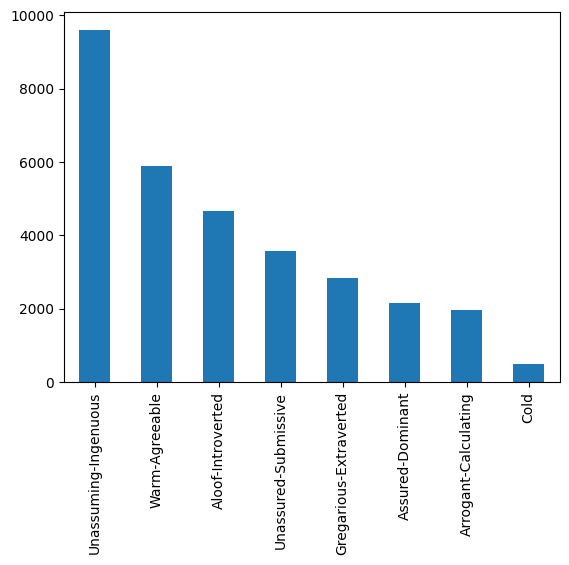

In [254]:
merge_df['social_orientation'].value_counts().plot(kind='bar')

In [ ]:
# save to file
dest_filepath = '~/Documents/data/charm/transformed/circumplex/gpt_labels_r1_mini_eval_text.csv'
merge_df.to_csv(dest_filepath, index=False)

In [257]:
merge_df['file_id'].nunique() * 0.8

248.8

## Error Analysis

**No utterance ID, speaker identifier, and/or social orientation tag**
- M01000F8S, Social orientation tag: Unassuming-Ingenuous
- M01000FCG, Overall, the conversation is characterized by a lack of assertiveness and a tendency towards introversion and self-doubt. Both speakers express dissatisfaction with their current situation and a desire for a romantic relationship, but Speaker 2 seems to be more focused on their high standards and reluctance to actively pursue a relationship.
M01000FK3, Social orientation tag: Unassured-Submissive
- M01000GBL, Speaker 2 (253): N/A. Explanation: The speaker is expressing a non-verbal emotion.

**Model attributes overlapping ranges of utterances to different speakers, resulting in multiple social orientation tags**
- M01000FCG, Speaker 1 (1-10): Unassured-Submissive. Speaker 1 expresses frustration and dissatisfaction with their job and their inability to take a nap during the day. They also mention being forgetful and not having done much at work. They seem to lack confidence and are not forceful in their speech.
- M01000FCG, Speaker 2 (5-35): Aloof-Introverted. Speaker 2 is reserved and not very talkative. They express disinterest in going to a singles party and describe the men there as nerdy and desperate. They also express their high standards for a partner and their reluctance to actively pursue a relationship. They seem to be focused inward and not very social.

**Model uses inconsistent formatting**
- Uses ranges of utterance ids (e.g. 20-30) (solved)
- Uses range of utterance ids (63, 66-83, 86-107) (M01000GND)
- Uses periods instead of parentheses (e.g. 42.) (solved)
- The model puts the explanation on the following line, follow 2 lines, or even following 3 lines (e.g. M01000GNZ, )
    - e.g. M01000GBL
    - Speaker 2 (253): N/A
    - Explanation: The speaker is expressing a non-verbal emotion.
    - e.g. M01000GQ4
    - Speaker 3 (54):  我同意，我们需要找到一个解决方案。
    - Social orientation tag: Warm-Agreeable
    - Explanation: Speaker 3 is agreeing with Speaker 2
- General statement about the conversation, unrelated to any single utterance (may not need to be solved) (e.g. M01000GE2)
    - Overall, the conversation is characterized by a warm and friendly tone, with both speakers showing concern for each other's well-being and offering support and advice.
- Some prompts only contain a single utterance, resulting in a malformed response (this should be solvable)
    - e.g. M01000GEL Speaker 1 (47):  好的呢
    - e.g. M01000GJ5 Speaker 2 (58):  [图片]

TODO: continue analyzing errors from index 40 onwards

In [213]:
df.sample(n=2)

,file_id,social_orientation,utterance_id,speaker_id,label_str
17858,M01000GNU,Warm-Agreeable,35.0,1.0,Speaker 1 (35): Warm-Agreeable - The speaker e...
25527,M01000GX3,Unassured-Submissive,30.0,2.0,Speaker 2 (30): Unassured-Submissive - The spe...


In [219]:
# df[df['utterance_id'].isna()].iloc[35:40]
# file_id = 'M01000GNU'
# label_obj[file_id][0]

# print(input_output[file_id][1][1]['choices'][0]['message']['content'])
# print(input_output[file_id][1][0]['messages'][1]['content'])#[1]['choices'][0]['message']['content'])
# idx = 0
# for prompt, response in input_output[file_id]:
#     print(idx)
#     print(response['choices'][0]['message']['content'])
#     idx+=1